
image 1/1 /content/0002.png: 480x640 1 ape, 1 can, 1 driller, 1 duck, 1 glue, 1 holepuncher, 444.1ms
Speed: 2.5ms preprocess, 444.1ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)


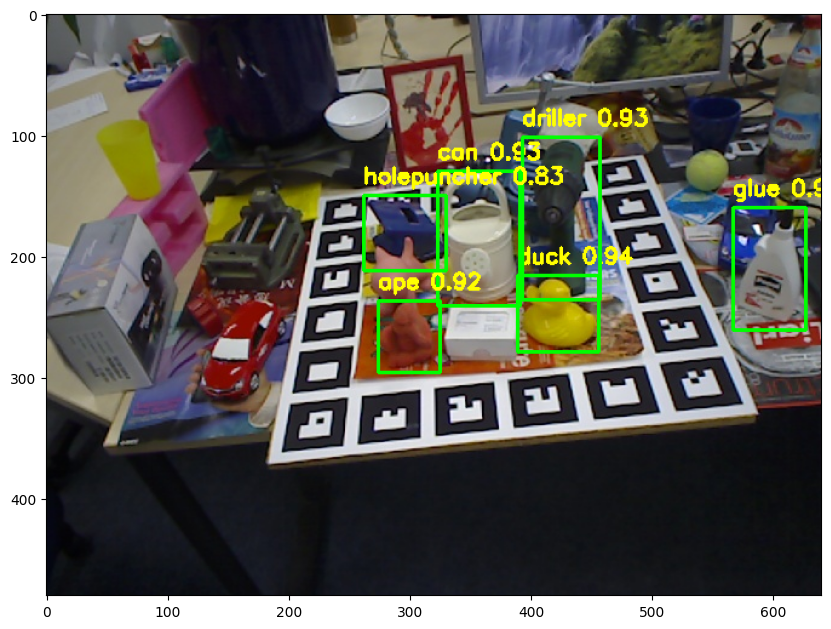

In [ ]:
# YOLO INFERENCE - OBJECT DETECTION ON TEST IMAGES
!pip install ultralytics
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 1. Load Trained Model
model = YOLO('/content/best.pt')  # Path to your trained model weights
CONF = 0.5  # Confidence threshold for detections

# 2. Define Class Names (Override)
# Tell the model: "Use these class names instead of the default ones"
new_names = {
    0: 'ape', 1: 'benchvise', 2: 'camera', 3: 'can', 4: 'cat',
    5: 'driller', 6: 'duck', 7: 'eggbox', 8: 'glue', 9: 'holepuncher',
    10: 'iron', 11: 'lamp', 12: 'phone'
}

# 3. Run Inference
img_path = '/content/0002.png'  # Path to the test image
results = model.predict(img_path, conf=CONF)

# 4. Visualize Results with Corrected Names
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Iterate through detected objects
for box in results[0].boxes:
    cls_id = int(box.cls[0])  # Class ID
    conf = float(box.conf[0])  # Confidence score

    # Use the corrected class names
    name = new_names[cls_id]

    # Get bounding box coordinates
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

    # Draw bounding box and label on image
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, f"{name} {conf:.2f}", (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title('YOLO Object Detection Results')
plt.show()

In [4]:
import os
import yaml

import ultralytics

model = ultralytics.YOLO('yolo11s_autolabel_final_with_80_th\\weights\\best.pt')

# CONFIGURAZIONE PERCORSI
# Percorso dove si trova il dataset originale (sola lettura)
input_root_dir = '../../Linemod_preprocessed/data' 
# Percorso dove vuoi creare la nuova struttura per YOLO
output_root_dir = 'Linemod_YOLO_Outputs'

def get_yolo_pred(img_path, target_id):
    """Esegue YOLO e filtra la BB per l'ID oggetto target."""
    results = model(img_path, verbose=False)
    best_bb = None
    max_conf = -1.0
    
    for r in results:
        boxes = r.boxes
        for box in boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            
            # Filtro: cerchiamo solo l'oggetto della cartella corrente
            if cls == target_id:
                if conf > max_conf:
                    max_conf = conf
                    # YOLO ritorna [x1, y1, x2, y2], convertiamo in [x, y, w, h]
                    b = box.xyxy[0].tolist()
                    best_bb = [int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])]
    
    return best_bb

def create_yolo_dataset_with_fallback():
    if not os.path.exists(output_root_dir):
        os.makedirs(output_root_dir)

    object_folders = [f for f in os.listdir(input_root_dir) 
                        if os.path.isdir(os.path.join(input_root_dir, f)) and f.isdigit()]

    for obj_id_folder in sorted(object_folders):
        target_id = int(obj_id_folder)
        obj_path = os.path.join(input_root_dir, obj_id_folder)
        rgb_path = os.path.join(obj_path, 'rgb')
        gt_file = os.path.join(obj_path, 'gt.yml') # Leggiamo la GT originale
        
        if not os.path.exists(rgb_path) or not os.path.exists(gt_file):
            continue
            
        # Carica GT originale per il fallback
        with open(gt_file, 'r') as f:
            gt_all = yaml.load(f, Loader=yaml.FullLoader)
            
        target_obj_path = os.path.join(output_root_dir, obj_id_folder)
        os.makedirs(target_obj_path, exist_ok=True)
        
        yolo_results_yaml = {}
        images = sorted([img for img in os.listdir(rgb_path) if img.endswith(('.png', '.jpg'))])
        
        print(f"Processing Object {target_id}...")
        
        for img_name in images:
            frame_id = int(os.path.splitext(img_name)[0])
            img_full_path = os.path.join(rgb_path, img_name)
            
            # 1. Tenta predizione YOLO
            pred_bb = get_yolo_pred(img_full_path, target_id)
            
            # 2. Logica di Fallback
            is_gt = False
            if pred_bb is None:
                # Se YOLO fallisce, prendi la BB dalla GT (indice 0 perché gt.yml ha liste)
                pred_bb = gt_all[frame_id][0]['obj_bb']
                is_gt = True
            
            # 3. Salva nel formato richiesto (identico a gt.yml)
            yolo_results_yaml[frame_id] = [{
                'obj_bb': pred_bb,
                'obj_id': target_id,
                'is_gt_fallback': is_gt # Utile per debug
            }]
        
        # Salvataggio file
        with open(os.path.join(target_obj_path, 'yolo.yaml'), 'w') as f:
            yaml.dump(yolo_results_yaml, f, sort_keys=True)

create_yolo_dataset_with_fallback()

Processing Object 1...


KeyboardInterrupt: 

In [ ]:
import pandas as pd

df = pd.read_csv('yolo11s_autolabel_final_with_80_th\\evaluation_results.csv')

df.rename(columns={'Class': 'Object',
                   'mAP50': 'mAP@50'},
            inplace=True)

df.reset_index(drop=True, inplace=True)

df.set_index('Object', inplace=True)

df

s = df.to_latex(float_format="%.3f")

print(s)

In [1]:
import ultralytics

model = ultralytics.YOLO('yolo11s_autolabel_final_with_80_th\\weights\\best.pt')

In [10]:
YOLO_LABELS = {
    0: 'ape',
    1: 'benchvise',
    2: 'camera',
    3: 'can',
    4: 'cat',
    5: 'driller',
    6: 'duck',
    7: 'eggbox',
    8: 'glue',
    9: 'holepuncher',
    10: 'iron',
    11: 'lamp',
    12: 'phone'
}


image 1/1 f:\Magistrale\Advanced Machine Learning\6D_pose\notebooks\yolo\..\..\Linemod_preprocessed\data\01\rgb\0000.png: 480x640 1 ape, 1 can, 1 duck, 1 glue, 1 holepuncher, 190.9ms
Speed: 1.7ms preprocess, 190.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


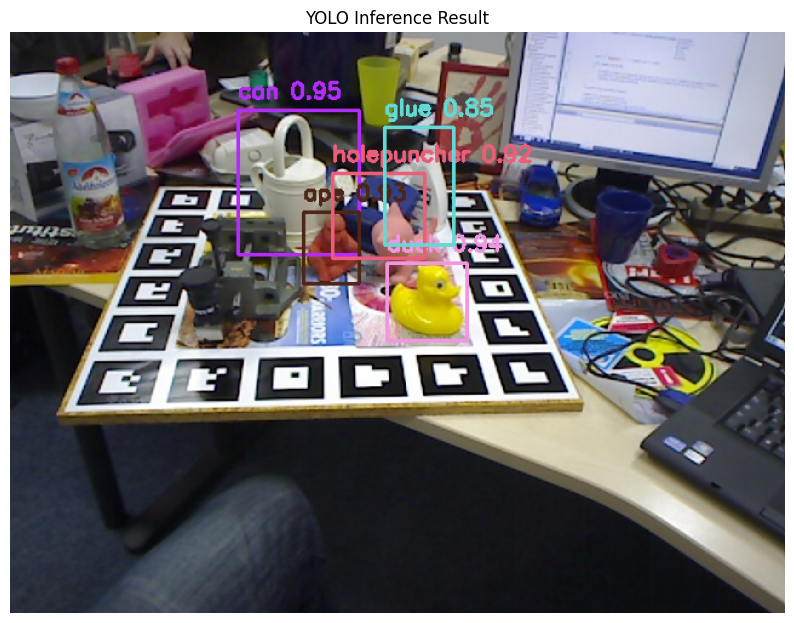

In [15]:
import cv2
import matplotlib.pyplot as plt
import random

img_path = '../../Linemod_preprocessed/data/01/rgb/0000.png'


res = model.predict(source=img_path)

img = cv2.imread(img_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10, 10))
for r in res:
    boxes = r.boxes
    for box in boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

        (r,g,b) = random.choices(range(256), k=3)
        cv2.rectangle(img, (x1, y1), (x2, y2), (r, g, b), 2)
        cv2.putText(img, f"{YOLO_LABELS[cls_id]} {conf:.2f}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (r, g, b), 2)

plt.imshow(img)
plt.axis('off')
plt.title('YOLO Inference Result')
plt.show()